# Imports 

In [310]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from scipy.stats import norm
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score

# Data Acquisition, Cleaning, and Wrangling

Data was acquired from Kaggle. Downloaded into a csv file directly from this link: https://www.kaggle.com/vipin20/loan-application-data

In [311]:
df = pd.read_csv('df1_loan.csv', index_col =0)
df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y,$5849.0
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,$6091.0
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,$3000.0
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,$4941.0
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,$6000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,LP002586,Female,Yes,1,Graduate,No,3326,913.0,105.0,84.0,1.0,Semiurban,Y,$4239.0
496,LP002587,Male,Yes,0,Not Graduate,No,2600,1700.0,107.0,360.0,1.0,Rural,Y,$4300.0
497,LP002588,Male,Yes,0,Graduate,No,4625,2857.0,111.0,12.0,NaN,Urban,Y,$7482.0
498,LP002600,Male,Yes,1,Graduate,Yes,2895,0.0,95.0,360.0,1.0,Semiurban,Y,$2895.0


The data was cleaned by dropping all null values and turning all qualitative data into quantitative data. For example, for marital status, *Yes* corresponds to 1, and *No* corresponds to 0

In [312]:
def clean_data(df):
    del df["Loan_ID"]

    df["Total_Income"]=df["Total_Income"].str.replace("$","")
    df["Total_Income"]=df["Total_Income"].apply(pd.to_numeric)

    df["Dependents"]=df["Dependents"].str.replace('+','')
    df["Dependents"]=df["Dependents"].apply(pd.to_numeric)


    df["Self_Employed"] = df["Self_Employed"].astype('category').cat.codes
    df["Gender"] = df["Gender"].astype('category').cat.codes
    df["Married"] = df["Married"].astype('category').cat.codes
    df["Education"] = df["Education"].astype('category').cat.codes
    df["Property_Area"] = df["Property_Area"].astype('category').cat.codes
    df["Loan_Status"] = df["Loan_Status"].astype('category').cat.codes


    df = df.dropna()

    return df

df = clean_data(df)

df.shape

(419, 13)

As a result of dropping null values, we can see the number of samples was reduced from 500 to 419. Additionally the Loan_ID is unnecssary for any model, thus the number of features was reduced to 13. The last data manipulation involved feature extraction. We believed that the size of a family (simply the addition of parents and dependents) and the principal per month (ratio of loan amount to its term) would be important features. 

In [313]:
def fam_size(df):
    fam_size = []
    for m, d in zip(df["Married"], df["Dependents"]):
        fam_size.append(1 + m + d)
    
    df["Family_Size"] = fam_size

    return df


def principal_per_month(df):
    principal_per_month = []
    for la, lat in zip(df["LoanAmount"], df["Loan_Amount_Term"]):
        principal_per_month.append(la / lat)
    
    df["Principal_Per_Month"] = principal_per_month

    return df

df = principal_per_month(fam_size(df))
df

C:\Users\maxnb\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\maxnb\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income,Family_Size,Principal_Per_Month
1,1,1,1.0,0,0,4583,1508.0,128.0,360.0,1.0,0,0,6091.0,3.0,0.355556
2,1,1,0.0,0,1,3000,0.0,66.0,360.0,1.0,2,1,3000.0,2.0,0.183333
3,1,1,0.0,1,0,2583,2358.0,120.0,360.0,1.0,2,1,4941.0,2.0,0.333333
4,1,0,0.0,0,0,6000,0.0,141.0,360.0,1.0,2,1,6000.0,1.0,0.391667
5,1,1,2.0,0,1,5417,4196.0,267.0,360.0,1.0,2,1,9613.0,4.0,0.741667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,1,1,0.0,0,0,3597,2157.0,119.0,360.0,0.0,0,0,5754.0,2.0,0.330556
495,0,1,1.0,0,0,3326,913.0,105.0,84.0,1.0,1,1,4239.0,3.0,1.250000
496,1,1,0.0,1,0,2600,1700.0,107.0,360.0,1.0,0,1,4300.0,2.0,0.297222
498,1,1,1.0,0,1,2895,0.0,95.0,360.0,1.0,1,1,2895.0,3.0,0.263889


Above can be seen the two extra features in the DataFrame.

Then we used two different algorithms to select the most important features from the DataFrame. The two algorithms used were SelectKBest and RandomForestRegressor

In [314]:
def k_best_features(k, features, target):
    
    X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=3000)
  
    selector = SelectKBest(f_regression, k = k)
    selector.fit(X_train, y_train)

    selected = selector.get_support()
  
    columns = []
    for i in range(len(selected)):
        if selected[i]:
            columns.append(df.columns[i])

    return columns

def random_forest_selection(k, features, target):
    X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(features, target, random_state=1000)

    model = RandomForestRegressor(max_depth=10, random_state=1000)
    model.fit(X_train_reg,y_train_reg)

    reg_columns = df.columns
    importances = model.feature_importances_
    indices = np.argsort(importances)[-k:]  # top 5 features

    plt.title('Regression Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [reg_columns[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()


In [315]:
def get_features_target(k_best=None):

    target_column = f"Loan_Status"
    target = df[target_column].dropna()

    df2 = df.copy()
    del df2[target_column]

    if k_best is not None:
        # if the k_best are requested, use the k_best_features function to select the best features and filter
        selected_names = k_best_features(k_best, df2, target)
        df2 = df.loc[df[target_column].notna(), selected_names]
        
    scaler = StandardScaler()
    scaler.fit(df2)
    df2 = scaler.transform(df2)

    return df2, target

features, target = get_features_target()


Selecting the top 5 features using each algorithm returns 4 of the same 5 features. Then we separated the features from the target.

['Education', 'LoanAmount', 'Credit_History', 'Property_Area', 'Family_Size']


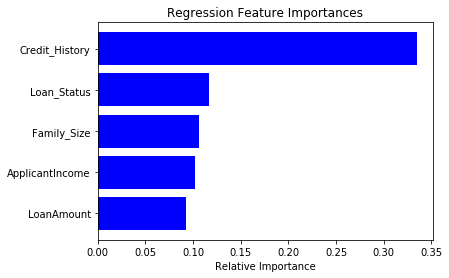

In [316]:
num_features = 5
print(k_best_features(num_features, features, target))
random_forest_selection(num_features, features, target)

# Data Visualization

In [317]:
def plot_data(f1, xlim, f2, ylim, target):
    x_t0 = []
    x_t1 = []
    for x1, x2, y in zip(df[f1], df[f2], target):
        if y == 0:
            x_t0.append([x1, x2])
        else:
            x_t1.append([x1, x2])
    
    x_t0 = np.array(x_t0)
    x_t1 = np.array(x_t1)

    plt.scatter(x_t0[:,0], x_t0[:,1], color='red', label='No', marker='o')
    plt.scatter(x_t1[:,0], x_t1[:,1], color='green', label='Yes', marker="o")

  
    plt.legend()
    plt.xlabel(f1)
    plt.ylabel(f2)
    ax = plt.gca()
    ax.autoscale(False)

    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.show()


#plot_data("LoanAmount", [0, 350], "ApplicantIncome", [0, 20000], target)
#plot_data("Credit_History", [-.5, 1.5], "ApplicantIncome", [0, 20000], target)
#plot_data("LoanAmount", [0, 350], "Family_Size", [0, 6], target)

#
# SHOULD CONSIDER MAKING Line/Bar graphs where x axis is a feature and y axis is percent of loans accepted at that feature value. This is for the features with only values of 0,1,2,3
#

# fig = plt.figure()
# ax = fig.add_axes([0,0,1,1])
# ax.bar(df["Family_Size"], perc_target)
# plt.show()

# for i in range(5):
#     #fam_size = df.loc[df["Family_Size"] == i, target]
#     iter = "Family_Size == " + str(i)
#     fam_size = df.query(iter)
#     perc_target = sum(fam_size) / len(fam_size)

# #print(perc_target)




# Training the Model

4 different classifiers will be used to trian and test the model:
    - Neural Network
    - SVM
    - Logistic Regressor
    - Decision Tree Classifier

In [318]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device: ', device)

class NN(nn.Module):
    def __init__(self, n_layers, hidden_size, activations):
        super().__init__()
            
        assert len(hidden_size) > 0
        act = {'sigmoid': nn.Sigmoid(), 'tanh': nn.Tanh(), 'relu': nn.ReLU(), 'identity': nn.Identity()}
        
        self.layers = []
        for i in range(n_layers - 1):
            self.layers.append(nn.Linear(hidden_size[i], hidden_size[i + 1]))
            if activations[i] in act:
                self.layers.append(act[activations[i]])
            else:
                assert activations in ['sigmoid', 'tanh', 'relu', 'identity']
        
        self.layers = nn.ModuleList(self.layers)

    def forward(self, x):
        for idx in range(len(self.layers) - 1):
            x = self.layers[idx](x)

        return x


device:  cuda:0


In [319]:
def train_nn(model, optimizer, criterion, n_epoch, data, label):
    data = torch.tensor(data, dtype=torch.float).to(device)

    label = label.tolist()
    label = torch.tensor(label, dtype=torch.long).squeeze().to(device)

    for epoch in range(n_epoch):
        predict = model(data)
        optimizer.zero_grad()
        loss = criterion(predict, label)
        loss.backward()
        optimizer.step()

    return model.named_parameters

def model_accuracy(model, data, label):
    data = torch.tensor(data, dtype=torch.float).to(device)
    
    predict = model(data)
    predict = torch.argmax(predict, dim=-1).cpu().detach().numpy()
    acc = accuracy_score(predict, label)

    return acc


In [320]:
n_epoch = 2000
learning_rate = 0.1
settings = {
'hidden layer = 1, neuron = 50': {'hs': [14, 50, 2], 'act': ['identity','relu', 'sigmoid']},
'hidden layer = 2, neuron = 30, 30': {'hs': [14, 30, 30, 2], 'act':['identity', 'relu', 'relu', 'sigmoid']},
'hidden layer = 2, neuron = 40, 40': {'hs': [14, 40, 40, 2], 'act':['identity', 'relu', 'relu', 'sigmoid']},
'hidden layer = 2, neuron = 50, 50': {'hs': [14, 50, 50, 2], 'act':['identity', 'relu', 'relu', 'sigmoid']},
'hidden layer = 2, neuron = 100, 100': {'hs': [14, 100, 100, 2], 'act':['identity', 'relu', 'relu', 'sigmoid']},
'hidden layer = 3, neuron = 50, 50, 50': {'hs': [14, 50, 50, 50, 2], 'act':['identity', 'relu', 'relu', 'relu', 'sigmoid']}}

X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=3000)
  

for setting in settings:
    print('---------------- Setting -------------------')
    print(setting)

    n_layers = len(settings[setting]['hs'])
    hidden_size = settings[setting]['hs']
    activations = settings[setting]['act']

    model = NN(n_layers, hidden_size, activations).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    param = train_nn(model, optimizer, criterion, n_epoch, X_train, y_train)

    print('Train Accuracy: ', model_accuracy(model, X_train, y_train))
    print('Test Accuracy: ', model_accuracy(model, X_test, y_test))


---------------- Setting -------------------
hidden layer = 1, neuron = 50
Train Accuracy:  0.8089171974522293
Test Accuracy:  0.8285714285714286
---------------- Setting -------------------
hidden layer = 2, neuron = 30, 30
Train Accuracy:  0.8439490445859873
Test Accuracy:  0.7428571428571429
---------------- Setting -------------------
hidden layer = 2, neuron = 40, 40
Train Accuracy:  0.8057324840764332
Test Accuracy:  0.7904761904761904
---------------- Setting -------------------
hidden layer = 2, neuron = 50, 50
Train Accuracy:  0.8057324840764332
Test Accuracy:  0.780952380952381
---------------- Setting -------------------
hidden layer = 2, neuron = 100, 100
Train Accuracy:  0.7101910828025477
Test Accuracy:  0.7523809523809524
---------------- Setting -------------------
hidden layer = 3, neuron = 50, 50, 50
Train Accuracy:  0.7707006369426752
Test Accuracy:  0.8


In [321]:

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

def train_logistic_regressor(features, target):
    X_train, X_test, y_train, y_test = train_test_split(features, target)
    
    solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    penalty =  ['l1','l2', 'elasticnet']
    c_values = [100, 10, 1.0, 0.1, 0.01]


    grid = dict(solver=solvers,penalty=penalty,C=c_values)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid_search = GridSearchCV(estimator=LogisticRegression(), param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

    grid_result = grid_search.fit(X_train, y_train)
  
    print("Best params", grid_result.best_params_)

    data_rows = []
    total_score = 0
    iters = 10
    for i in range(iters):
        X_train, X_test, y_train, y_test = train_test_split(features, target)
        model = LogisticRegression(max_iter=20000, **grid_result.best_params_).fit(X_train, y_train)

        train_acc = model.score(X_train, y_train)
        test_acc = model.score(X_test, y_test)

        total_score += test_acc

        data_rows.append({
            "train_acc": train_acc,
            "test_acc": test_acc
        })

    test_df = pd.DataFrame(data_rows)
    print('average score', total_score/iters, '\n',test_df)



In [322]:
def train_SVM(features, target):
    X_train, X_test, y_train, y_test = train_test_split(features, target)
    
    kernel = ['linear', 'poly', 'rbf', 'sigmoid']
    c_values = [50, 10, 1.0, 0.1, 0.01]
    gamma = ['scale', 'auto']

    grid = dict(kernel=kernel,C=c_values,gamma=gamma)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid_search = GridSearchCV(estimator=SVC(), param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

    grid_result = grid_search.fit(X_train, y_train)
  
    print("Best params", grid_result.best_params_)

    data_rows = []
    total_score = 0
    iters = 10
    for i in range(iters):
        X_train, X_test, y_train, y_test = train_test_split(features, target)
        model = SVC(max_iter=20000, **grid_result.best_params_).fit(X_train, y_train)

        train_acc = model.score(X_train, y_train)
        test_acc = model.score(X_test, y_test)

        total_score += test_acc

        data_rows.append({
            "train_acc": train_acc,
            "test_acc": test_acc
        })

    test_df = pd.DataFrame(data_rows)
    print('average score', total_score/iters, '\n',test_df)

In [323]:
train_logistic_regressor(features, target)
train_SVM(features, target)


Best params {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
average score 0.8114285714285714 
    train_acc  test_acc
0   0.808917  0.800000
1   0.796178  0.838095
2   0.805732  0.809524
3   0.815287  0.780952
4   0.808917  0.800000
5   0.808917  0.800000
6   0.802548  0.819048
7   0.802548  0.819048
8   0.808917  0.800000
9   0.792994  0.847619
Best params {'C': 1.0, 'gamma': 'scale', 'kernel': 'sigmoid'}
average score 0.7952380952380952 
    train_acc  test_acc
0   0.786624  0.790476
1   0.799363  0.771429
2   0.761146  0.819048
3   0.786624  0.800000
4   0.764331  0.866667
5   0.796178  0.780952
6   0.789809  0.742857
7   0.792994  0.752381
8   0.780255  0.800000
9   0.783439  0.828571


In [334]:
features, target = get_features_target(k_best = 4)
print(features.shape)
train_logistic_regressor(features, target)
train_SVM(features, target)

(419, 4)
Best params {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
average score 0.8257142857142856 
    train_acc  test_acc
0   0.792994  0.847619
1   0.812102  0.790476
2   0.789809  0.857143
3   0.805732  0.809524
4   0.802548  0.819048
5   0.799363  0.828571
6   0.786624  0.866667
7   0.808917  0.800000
8   0.802548  0.819048
9   0.802548  0.819048
Best params {'C': 50, 'gamma': 'scale', 'kernel': 'linear'}
average score 0.8066666666666666 
    train_acc  test_acc
0   0.802548  0.819048
1   0.808917  0.800000
2   0.812102  0.790476
3   0.805732  0.809524
4   0.815287  0.780952
5   0.815287  0.780952
6   0.799363  0.828571
7   0.812102  0.790476
8   0.789809  0.857143
9   0.805732  0.809524
